# Homework 3

*Machine Learning Classification Model*

*Task: Credit score classification (Kaggle LINK: [URL](https://www.kaggle.com/datasets/parisrohan/credit-score-classification?select=train.csv))**

In [1]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest,SelectPercentile,f_classif
from sklearn.feature_selection import f_regression,mutual_info_regression,mutual_info_classif
from sklearn.feature_selection import SelectFromModel,RFE,VarianceThreshold

In [2]:
data = pd.read_csv("train.csv") # 读取数据
df = data.copy()

C:\Users\19436\AppData\Local\Temp\ipykernel_28200\1035956267.py:1: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("train.csv") # 读取数据


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 28 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   ID                        100000 non-null  object 
 1   Customer_ID               100000 non-null  object 
 2   Month                     100000 non-null  object 
 3   Name                      90015 non-null   object 
 4   Age                       100000 non-null  object 
 5   SSN                       100000 non-null  object 
 6   Occupation                100000 non-null  object 
 7   Annual_Income             100000 non-null  object 
 8   Monthly_Inhand_Salary     84998 non-null   float64
 9   Num_Bank_Accounts         100000 non-null  int64  
 10  Num_Credit_Card           100000 non-null  int64  
 11  Interest_Rate             100000 non-null  int64  
 12  Num_of_Loan               100000 non-null  object 
 13  Type_of_Loan              88592 non-null   ob

## Task 1
- 任务1：完成数据预处理（缺失处理、异常值处理等），及对分析有帮助的可视化分析，并尝试选择合适的变量，阐述选择的过程及原因

In [4]:
'''
*******************************************
PREPROCESSING
1. 数据类型处理
*******************************************
'''

def regex_decimal(x):
    '''Extract numbers in text'''
    regex = r'[-+]?\d+(?:\.\d+)?'
    matches = re.search(regex, x)
    if matches != None:
        return float(matches[0])
    else:
        return 0.0

def regex_int(x):
    '''Extract numbers in text'''
    regex = r'[-+]?\d+(?:\.\d+)?'
    matches = re.search(regex, x)
    if matches != None:
        return int(matches[0])
    else:
        return 0

def Num_of_Delayed_Payment(x):
    if isinstance(x, str):
        x = regex_int(x)
    return x

def Changed_Credit_Limit(x):
    if isinstance(x, str):
        x = regex_decimal(x)
    return x

def Amount_invested_monthly(x):
    if isinstance(x, str):
        x = regex_decimal(x)
    return x
    
def Monthly_Balance(x):
    if isinstance(x, str):
        x = regex_decimal(x)
    return x


# Annual_Income转为数值型
df['Annual_Income'] = df['Annual_Income'].apply(regex_decimal)

# Num_of_Loan
df['Num_of_Loan'] = df['Num_of_Loan'].apply(regex_int)

# Num_of_Delayed_Payment
df['Num_of_Delayed_Payment'] = df['Num_of_Delayed_Payment'].apply(Num_of_Delayed_Payment)

# Changed_Credit_Limit
df['Changed_Credit_Limit'] = df['Changed_Credit_Limit'].apply(Changed_Credit_Limit)

# Outstanding_Debt
df['Outstanding_Debt'] = df['Outstanding_Debt'].apply(regex_decimal)

# Amount_invested_monthly
df['Amount_invested_monthly'] = df['Amount_invested_monthly'].apply(Amount_invested_monthly)

# 将Monthly Balance中的数据转换为数值型，无法转换的处理为 NaN
df['Monthly_Balance'] = pd.to_numeric(df['Monthly_Balance'], errors="coerce")

In [5]:
'''
*******************************************
PREPROCESSING
2. 处理缺失值
*******************************************
'''
def same_user_fill(df, col):
    # 用该用户其它月份该列的值填充缺失值
    nan_index = df[df[col].isnull()].index
    for each_index in nan_index:
        Customer_ID = df.loc[each_index, 'Customer_ID']
        # 该用户子表
        temp_df = df[df['Customer_ID'] == Customer_ID]
        notnan = temp_df[temp_df[col].notnull()]
        if len(notnan) > 0:
            if col == 'Monthly_Inhand_Salary' or col == 'Num_Credit_Inquiries':
                value = notnan.loc[notnan.index[0], col]
            elif col == 'Amount_invested_monthly' or col == 'Monthly_Balance':
                value = notnan[col].mean()
        else:
            if col == 'Monthly_Inhand_Salary':
                value = df.loc[each_index, 'Annual_Income'] / 12.0
            else:
                value = df[col].mean()
        df.loc[each_index, col] = value
    return df

# Monthly_Inhand_Salary
# 某个Customer的缺失值，填充为该Customer其它Monthly_Inhand_Salary的值
df = same_user_fill(df, 'Monthly_Inhand_Salary')

# Num_of_Delayed_Payment
# 用0填充
df['Num_of_Delayed_Payment'].fillna(0.0, inplace=True)

# Num_Credit_Inquiries
# 某个Customer的缺失值，填充为该Customer其它Num_Credit_Inquiries的值
df = same_user_fill(df, 'Num_Credit_Inquiries')

# Credit_History_Age
# Nan -> 0; a Year b month -> a*12+b;
df['Credit_History_Age'].fillna(0, inplace=True)

def Credit_History_Age(x):
    if isinstance(x, str):
        regex_year = r'(\d*) Years'
        regex_month = r'(\d*) Months'

        year_num = int(re.search(regex_year, x).groups()[0])
        month_num = int(re.search(regex_month, x).groups()[0])
        x = 12 * year_num + month_num
    return x

df['Credit_History_Age'] = df['Credit_History_Age'].apply(Credit_History_Age)

# Amount_invested_monthly
# 某个Customer的缺失值，填充为该Customer其它Amount_invested_monthly的平均值
df = same_user_fill(df, 'Amount_invested_monthly')

# Monthly_Balance
# 某个Customer的缺失值，填充为该Customer其它Monthly_Balance的平均值
df = same_user_fill(df, 'Monthly_Balance')

In [6]:
df.info() # loan

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 28 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   ID                        100000 non-null  object 
 1   Customer_ID               100000 non-null  object 
 2   Month                     100000 non-null  object 
 3   Name                      90015 non-null   object 
 4   Age                       100000 non-null  object 
 5   SSN                       100000 non-null  object 
 6   Occupation                100000 non-null  object 
 7   Annual_Income             100000 non-null  float64
 8   Monthly_Inhand_Salary     100000 non-null  float64
 9   Num_Bank_Accounts         100000 non-null  int64  
 10  Num_Credit_Card           100000 non-null  int64  
 11  Interest_Rate             100000 non-null  int64  
 12  Num_of_Loan               100000 non-null  int64  
 13  Type_of_Loan              88592 non-null   ob

In [7]:
'''
*******************************************
Feature Engineering
1. Drop useless column
2. Visualization
*******************************************
'''

# 1. Drop useless column
df.drop(['ID', 'Customer_ID', 'Month', 'Name', 
         'Type_of_Loan', 'SSN', 'Occupation', 'Age'], axis=1, inplace=True)

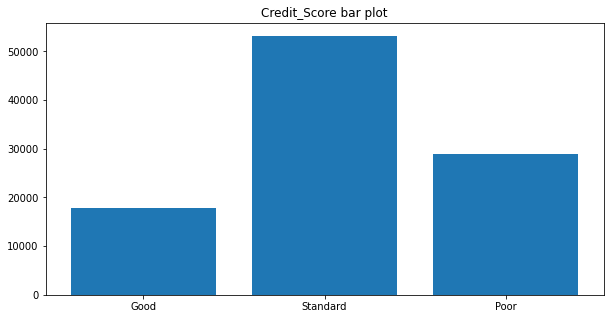

In [29]:
# 2. Visualization
# 2.1 绘制各个类别上的数据量图
def credit_score_count_plot(ax, col, df):
    column_cls_list = df['Credit_Score'].unique()
    cls_list_num = [len(df[df['Credit_Score'] == each_cls]) for each_cls 
                    in column_cls_list]
    ax.set_title('{} bar plot'.format(col))
    ax.bar(column_cls_list, cls_list_num)
    return ax

f, axs = plt.subplots(1,1, figsize=(10,5))
axs = credit_score_count_plot(axs, 'Credit_Score', df)
plt.show()

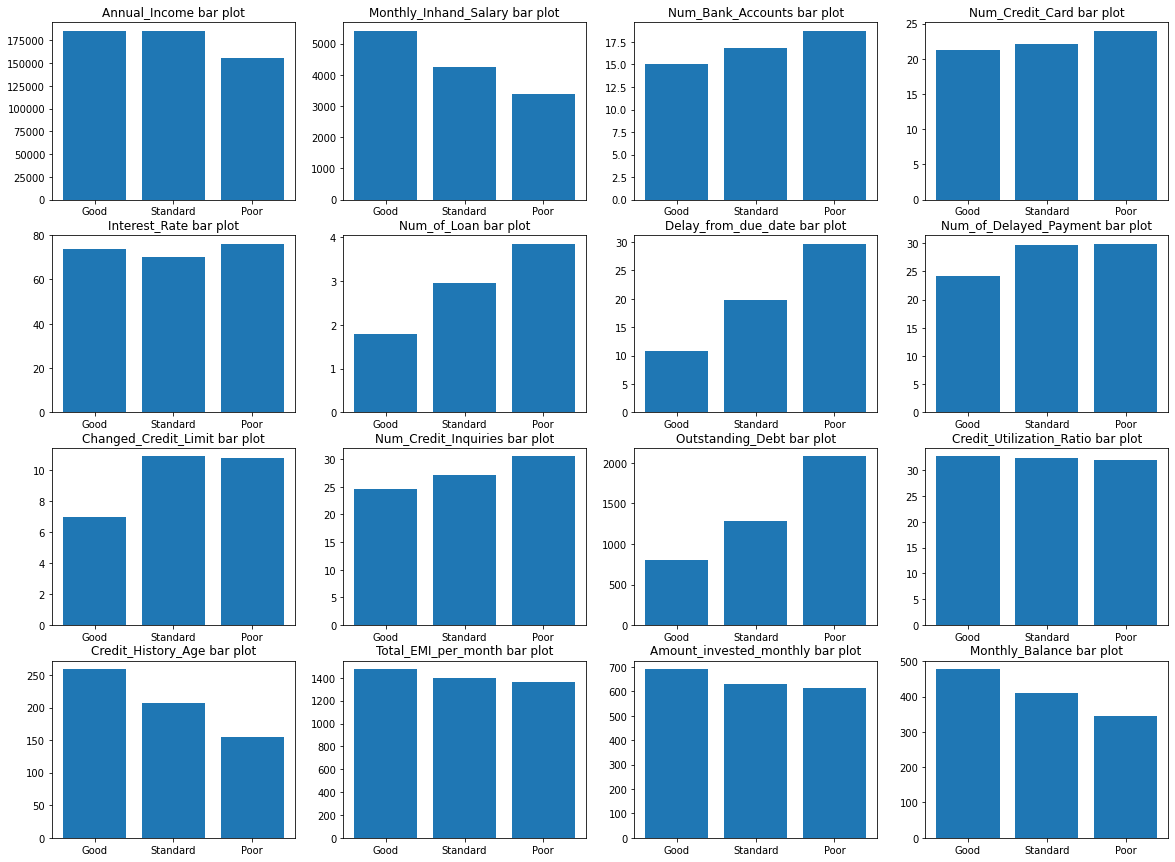

In [67]:
# 2.2 各个目标类别在各个特征值上的violin plot
def credit_score_violin(ax, feature, df):
    column_cls_list = df['Credit_Score'].unique()
    cls_list_num = [df[df['Credit_Score'] == each_cls][feature].mean()
                    for each_cls in column_cls_list]
    ax.set_title('{} bar plot'.format(feature))
    ax.bar(column_cls_list, cls_list_num)
    return ax

df_temp = df.drop(['Payment_of_Min_Amount', 'Credit_Mix', 'Credit_Score', 'Payment_Behaviour'], axis=1)
f, axs = plt.subplots(4,4, figsize=(20,15))
for i in range(4):
    for j in range(4):
        axs[i][j] = credit_score_violin(axs[i][j], 
                                        df_temp.columns[i*4+j],
                                        df)

C:\Users\19436\AppData\Local\Temp\ipykernel_28200\3179775809.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(),annot=True, mask=np.triu(df.corr(),k=1))


<AxesSubplot:>

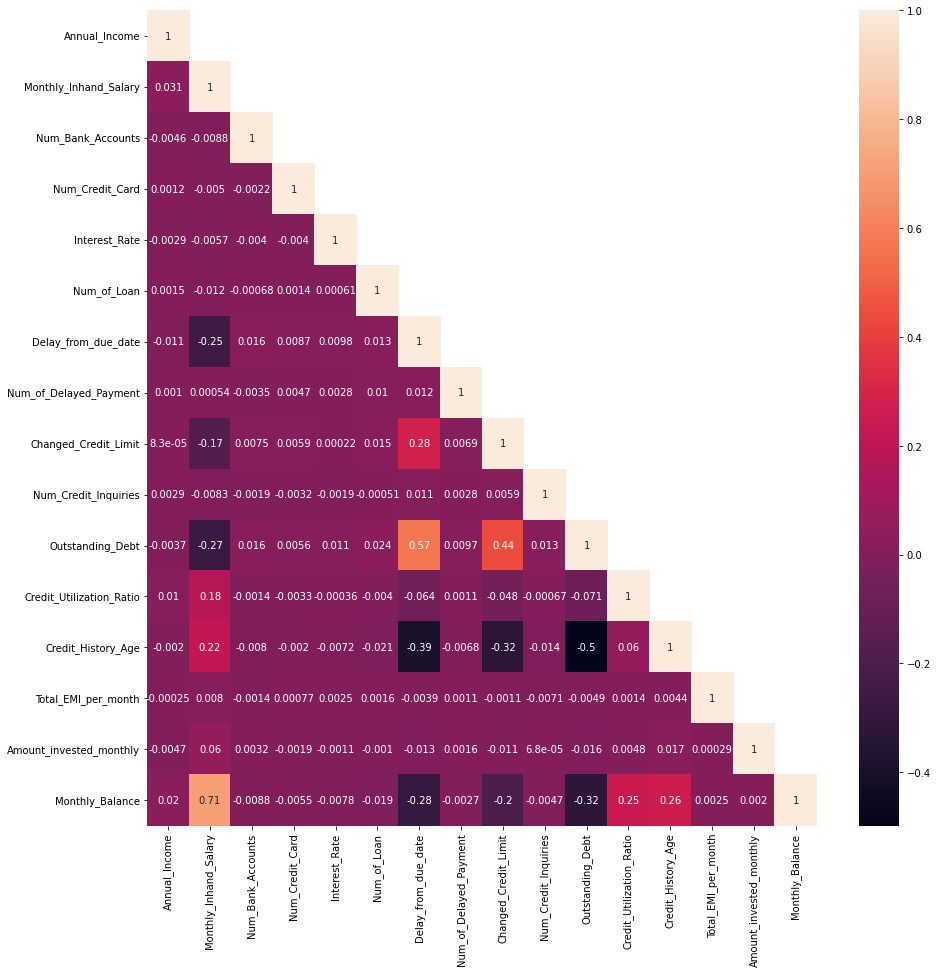

In [30]:
# 2.3 Correlation Matrix
plt.figure(figsize=(15,15))
sns.heatmap(df.corr(),annot=True, mask=np.triu(df.corr(),k=1))

## Task2

【至少使用三个分类算法】（如决策树、支撑向量机、boosting方法等）,对Credit score建立分类模型。

可自行将数据划分为测试集与训练集，
可以使用交叉验证的方法，对模型结果根据常用分类指标（如accuracy,precision,recall,f1 score等）进行模型比较与评价。

In [91]:
def alter_label(x):
    if x == 'Poor':
        return 0
    elif x == 'Standard':
        return 1
    elif x == 'Good':
        return 2
    
y = df['Credit_Score'].apply(alter_label)
X = pd.get_dummies(df[['Annual_Income', 'Monthly_Inhand_Salary', 
                       'Num_Bank_Accounts','Num_Credit_Card',
                       'Interest_Rate', 'Num_of_Loan',
                       'Delay_from_due_date', 'Num_of_Delayed_Payment',
                       'Changed_Credit_Limit','Num_Credit_Inquiries',
                       'Credit_Mix', 'Outstanding_Debt',
                       'Credit_Utilization_Ratio', 'Credit_History_Age',
                       'Payment_of_Min_Amount', 'Total_EMI_per_month',
                       'Amount_invested_monthly', 'Payment_Behaviour',
                       'Monthly_Balance']])

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    random_state=17, 
                                                    test_size=.20)

print(len(X_train), len(X_test))

80000 20000


In [98]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score, precision_score, recall_score, make_scorer

In [105]:
'''
Decision Tree
'''
from sklearn.tree import DecisionTreeClassifier


clf = DecisionTreeClassifier(random_state=7)

'''
十折交叉验证
- 将数据集划分为10份，每次取其中一份为validation，9份为train
- 
'''
kfold = KFold(n_splits=10)
result = cross_val_score(clf, X_train, y_train, cv=kfold, 
                         scoring=make_scorer(f1_score, average='micro')) 
print(result)

[0.701625 0.687625 0.700125 0.694375 0.708875 0.689625 0.689    0.693625
 0.69425  0.690375]


In [109]:
'''
Support Vector Machine
'''
from sklearn.svm import LinearSVC


clf = LinearSVC(penalty='l2', random_state=7, multi_class='ovr')

kfold = KFold(n_splits=10)
result = cross_val_score(clf, X_train, y_train, cv=kfold,
                         scoring=make_scorer(f1_score, average='micro')) 
print(result)

array([0.58425 , 0.2215  , 0.30525 , 0.3135  , 0.41825 , 0.5365  ,
       0.493875, 0.47475 , 0.539375, 0.444   ])

In [110]:
'''
Boosting Method
'''
from sklearn.ensemble import GradientBoostingClassifier


clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
                                 max_depth=1, random_state=0)

kfold = KFold(n_splits=10)
result = cross_val_score(clf, X_train, y_train, cv=kfold, 
                         scoring=make_scorer(f1_score, average='micro')) 
print(result, result.mean())

[0.67525  0.677375 0.676125 0.680625 0.685875 0.662875 0.680125 0.676375
 0.677125 0.677125] 0.6768875


上述三个模型，经过10折交叉验证，并使用f1值判断模型的性能并进行性能比较

f1值具有综合考虑$Precion$和$Recall$的能力，能够更好地判断分类模型的性能，f1值的计算公式如下：
$$f1=\frac{2 \times (precision \times recall)}{precision + recall}$$

对比三个分类模型，boosting方法得到的分类模型效果较好